## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

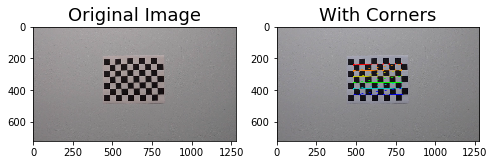

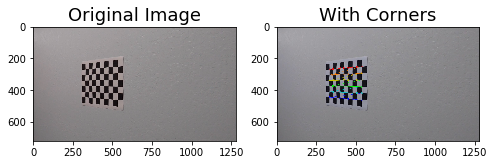

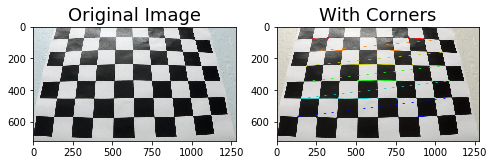

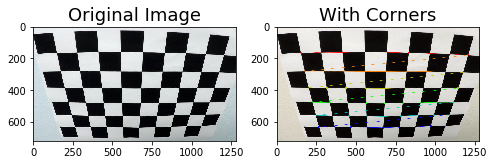

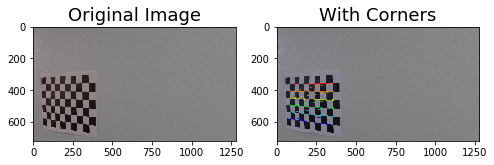

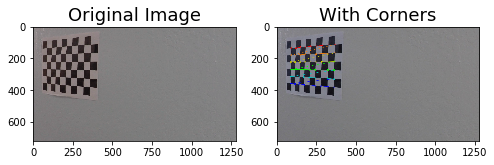

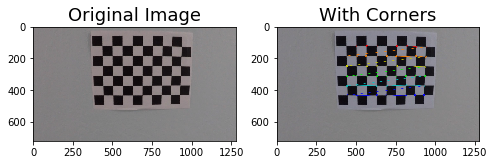

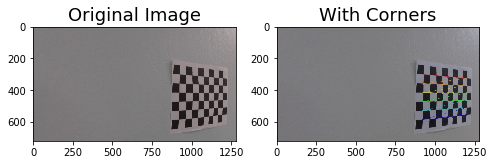

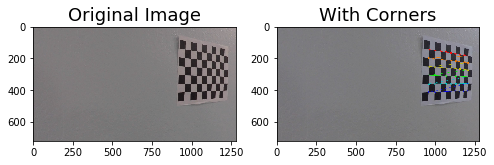

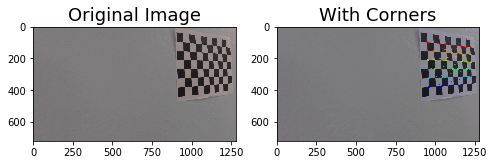

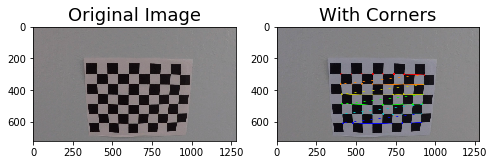

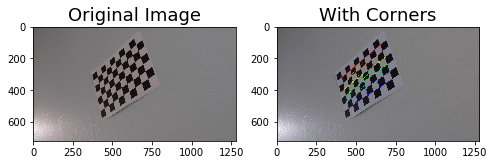

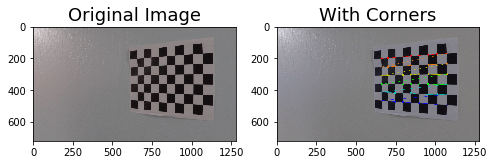

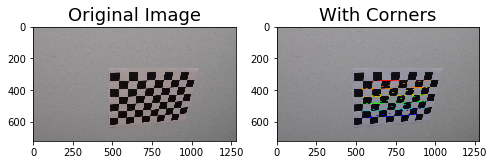

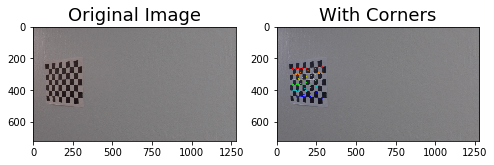

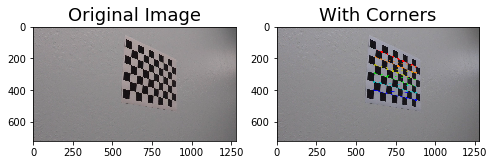

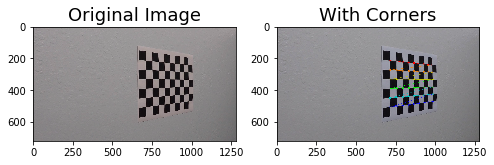

In [2]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
img_size = None
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    offset = 100 # offset for dst points

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners', fontsize=18)

## And so on and so forth...

In [3]:
# For source points I'm grabbing the outer four detected corners
src = np.float32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
    [(img_size[0] / 6), img_size[1]],
    [(img_size[0] * 5 / 6) + 50, img_size[1]],
    [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])
dst = np.float32(
    [[((img_size[0] / 4)), 200],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [((img_size[0] * 3 / 4)), 200]])
print (src, dst)
# # Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

[[ 580.       460.     ]
 [ 213.33333  720.     ]
 [1116.6666   720.     ]
 [ 700.       460.     ]] [[320. 200.]
 [320. 720.]
 [960. 720.]
 [960. 200.]]


In [4]:
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
print(img_size)

(1280, 720)


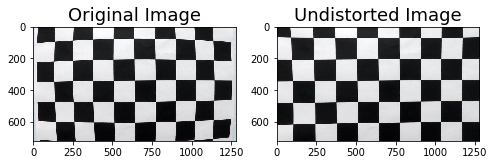

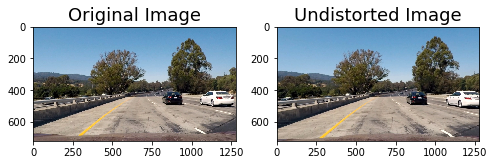

In [5]:
dist_img = cv2.imread("../camera_cal/calibration1.jpg")
# Draw undistorted image and distorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.imshow(dist_img)
ax1.set_title('Original Image', fontsize=18)
ax2.imshow(cv2.undistort(dist_img, mtx, dist, None, mtx))
ax2.set_title('Undistorted Image', fontsize=18)
plt.savefig("../output_images/undistort_chessboard.jpg", dpi = 300)

dist_img = mpimg.imread("../test_images/test1.jpg")
# Draw undistorted image and distorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.imshow(dist_img)
ax1.set_title('Original Image', fontsize=18)
ax2.imshow(cv2.undistort(dist_img, mtx, dist, None, mtx))
ax2.set_title('Undistorted Image', fontsize=18)
plt.savefig("../output_images/undistort_test1.jpg", dpi = 300)

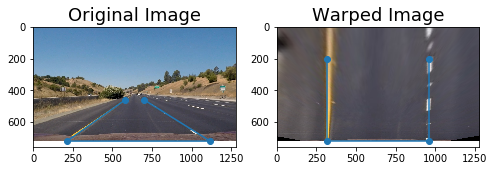

In [6]:
image = mpimg.imread("../test_images/straight_lines1.jpg")
undist = cv2.undistort(image, mtx, dist, None, mtx)
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

# Draw undistorted image and distorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.imshow(image)
ax1.plot(src[:,0],src[:,1], 'o-')
ax1.set_title('Original Image', fontsize=18)
ax2.imshow(warped)
ax2.plot(dst[:,0],dst[:,1],'o-')
ax2.set_title('Warped Image', fontsize=18)
plt.savefig("../output_images/warpPerspective_points.jpg", dpi = 300)

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= min(thresh)) & (scaled_sobel <= max(thresh))] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [8]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [9]:
def curvature(left_line, right_line):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

#     print (len(left_line.allx*ym_per_pix), len(left_line.allx*xm_per_pix))
    left_y_eval = np.max(left_line.ally)
    right_y_eval = np.max(right_line.ally)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(left_line.ally*ym_per_pix, left_line.allx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_line.ally*ym_per_pix, right_line.allx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*left_y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*right_y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad
    # Example values: 632.1 m    626.2 m

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

left_line = Line()
right_line = Line()

def find_lines(binary_warped):
    global left_line
    global right_line
    
    if not left_line.detected and not right_line.detected:
        left_line.detected = True
        right_line.detected = True
        
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
#         out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
#         print(midpoint)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
#             cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
#             (0,255,0), 2) 
#             cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
#             (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        print (lefty[45], righty[45])

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        #polynomial coefficients for the most recent fit
        left_line.current_fit = left_fit
        #x values for detected line pixels
        left_line.allx = leftx  
        #y values for detected line pixels
        left_line.ally = lefty

        #polynomial coefficients for the most recent fit
        right_line.current_fit = right_fit
        #x values for detected line pixels
        right_line.allx = rightx  
        #y values for detected line pixels
        right_line.ally = righty
        
    else:
        
#         if (len(left_line.recent_xfitted) > 5):
#             left_line.recent_xfitted.pop(0)
#         left_line.recent_xfitted.append(left_line.current_fit)
#         left_line.bestx = np.mean(left_line.recent_xfitted, axis=0)
#         if (len(right_line.recent_xfitted) > 5):
#             right_line.recent_xfitted.pop(0)
#         right_line.recent_xfitted.append(right_line.current_fit)
#         right_line.bestx = np.mean(right_line.recent_xfitted, axis=0)
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_line.current_fit[0]*(nonzeroy**2) + left_line.current_fit[1]*nonzeroy + 
        left_line.current_fit[2] - margin)) & (nonzerox < (left_line.current_fit[0]*(nonzeroy**2) + 
        left_line.current_fit[1]*nonzeroy + left_line.current_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_line.current_fit[0]*(nonzeroy**2) + right_line.current_fit[1]*nonzeroy + 
        right_line.current_fit[2] - margin)) & (nonzerox < (right_line.current_fit[0]*(nonzeroy**2) + 
        right_line.current_fit[1]*nonzeroy + right_line.current_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_line.current_fit = np.polyfit(lefty, leftx, 2)
        left_line.allx = leftx  
        left_line.ally = lefty
        right_line.current_fit = np.polyfit(righty, rightx, 2)
        right_line.allx = rightx  
        right_line.ally = righty
        
    #radius of curvature of the lines in meters
    left_line.radius_of_curvature, right_line.radius_of_curvature = curvature(left_line, right_line)
    
    return left_line, right_line
    #     return nonzerox, nonzeroy, left_lane_inds, right_lane_inds, left_fit, right_fit

In [11]:
example = True
from matplotlib.backends.backend_pdf import PdfPages
import scipy
def process_image(image):
    
    global left_line
    global right_line
    global example
    
    folder = "../output_images/"
    
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # result = get_lines(image)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    if example:
        plt.imshow(undist)
        plt.title("undist")
        plt.savefig(folder+"undist.jpg", dpi = 300)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    if example:
        plt.imshow(warped)
        plt.title("warped")
        plt.savefig(folder+"warped.jpg", dpi = 300)
    
    ksize = 3
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    if example:
        plt.imshow(gradx)
        plt.title("gradx")
        plt.savefig(folder+"gradx.jpg", dpi = 300)
    mag_binary = mag_thresh(warped, sobel_kernel=ksize, mag_thresh=(30, 100))
    if example:
        plt.imshow(mag_binary)
        plt.title("mag_binary")
        plt.savefig(folder+"mag_binary.jpg", dpi = 300)
    dir_binary = dir_threshold(warped, sobel_kernel=ksize, thresh=(0.7, 1.3))
    if example:
        plt.imshow(dir_binary)
        plt.title("dir_binary")
        plt.savefig(folder+"dir_binary.jpg", dpi = 300)
    hls_binary = hls_select(warped, thresh=(90, 255))
    if example:
        plt.imshow(hls_binary)
        plt.title("hls_binary")
        plt.savefig(folder+"hls_binary.jpg", dpi = 300)
    
    binary_warped = np.zeros_like(gradx)
    binary_warped[(gradx == 1 | ((mag_binary == 1) & (dir_binary == 1))) | hls_binary == 1] = 1
    if example:
        plt.imshow(binary_warped)
        plt.title("binary_warped")
        plt.savefig(folder+"binary_warped.jpg", dpi = 300)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    find_lines(binary_warped)
    left_fitx = left_line.current_fit[0]*ploty**2 + left_line.current_fit[1]*ploty + left_line.current_fit[2]
    right_fitx = right_line.current_fit[0]*ploty**2 + right_line.current_fit[1]*ploty + right_line.current_fit[2]
        
    
#     # Sanity check
    lane_width_pixels = abs(right_fitx[image.shape[0]-1]-left_fitx[image.shape[0]-1])
#     lane_width_pixels_top = abs(right_fitx[0]-left_fitx[0])
#     lane_width_sanity = abs(lane_width_pixels-lane_width_pixels_top)
    
#     curvature_sanity = abs(left_line.radius_of_curvature-right_line.radius_of_curvature)
    
#     if (len(left_lane.recent_xfitted) == 5):
#         left_lane.recent_xfitted.pop(0)
#     left_lane.recent_xfitted.append(left_fitx)
#     self.bestx = np.mean(left_lane.recent_xfitted)
        
    image_center_x = image.shape[1]/2
    offset = image_center_x-(abs(left_fitx[image.shape[0]-1]+right_fitx[image.shape[0]-1])/2)
    lane_width_meters = 3.7
    lane_width_metersperpixel = lane_width_meters/lane_width_pixels
    offset_meters = offset*lane_width_metersperpixel
    
    side = ""
    if offset_meters <= 0:
        side = "left"
    else:
        side = "right"
        
    # TODO: set offset in lane objet
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    lane_color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    lane_color_warp[left_line.ally, left_line.allx] = [255, 0, 0]
    lane_color_warp[right_line.ally, right_line.allx] = [0, 0, 255]
    if example:
        plt.imshow(lane_color_warp)
        plt.plot(left_fitx, ploty, 'g-', right_fitx, ploty, 'g-')
        plt.title("lane_color_warp")
        plt.savefig(folder+"lane_color_warp.jpg", dpi = 300)
        plt.clf()
        
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    if example:
        plt.imshow(color_warp)
        plt.title("color_warp")
        plt.savefig(folder+"color_warp.jpg", dpi = 300)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    newlanecolorwarp = cv2.warpPerspective(lane_color_warp, Minv, (image.shape[1], image.shape[0])) 
    if example:
        plt.imshow(newwarp)
        plt.title("newwarp")
        plt.savefig(folder+"newwarp.jpg", dpi = 300)
        plt.imshow(newlanecolorwarp)
        plt.title("newlanecolorwarp")
        plt.savefig(folder+"newlanecolorwarp.jpg", dpi = 300)
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    result = cv2.addWeighted(result, 1, newlanecolorwarp, 1, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Radius of Curvature is %.2fkm' % (np.mean([left_line.radius_of_curvature, right_line.radius_of_curvature])/1000), (10,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Vehicle is %.2fm %s of center' % (abs(offset_meters),side), (10,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    if example:
        plt.imshow(result)
        plt.title("result")
        plt.savefig(folder+"result.jpg", dpi = 300)
#     combined_255 = combined*255
    
#     color = cv2.cvtColor(combined_255, cv2.COLOR_GRAY2RGB)
    
#     plt.imshow(result)
#     plt.show()

#     plt.imshow(undist)
#     plt.figure()
#     plt.imshow(warped)
#     plt.show()

    example = False
    
    return result

641 642
[MoviePy] >>>> Building video ../output_images/project_video_lanes.mp4
[MoviePy] Writing video ../output_images/project_video_lanes.mp4


100%|█████████▉| 1260/1261 [03:21<00:00,  6.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_images/project_video_lanes.mp4 



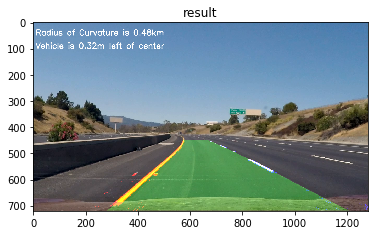

In [12]:
undist_output = '../output_images/project_video_lanes.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../project_video.mp4")
clip1_undist = clip1.fl_image(process_image) #NOTE: this function expects color images!!
clip1_undist.write_videofile(undist_output, audio=False)

# undist_output = '../challenge_video_lanes.mp4'
# ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
# ## To do so add .subclip(start_second,end_second) to the end of the line below
# ## Where start_second and end_second are integer values representing the start and end of the subclip
# ## You may also uncomment the following line for a subclip of the first 5 seconds
# ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
# clip1 = VideoFileClip("../challenge_video.mp4")
# clip1_undist = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# clip1_undist.write_videofile(undist_output, audio=False)

# undist_output = '../harder_challenge_video_lanes.mp4'
# ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
# ## To do so add .subclip(start_second,end_second) to the end of the line below
# ## Where start_second and end_second are integer values representing the start and end of the subclip
# ## You may also uncomment the following line for a subclip of the first 5 seconds
# ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
# clip1 = VideoFileClip("../harder_challenge_video.mp4")
# clip1_undist = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# clip1_undist.write_videofile(undist_output, audio=False)